In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

# import data

In [2]:
data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

In [3]:
#merge train/test data
data['label'] = 'train'
test_data['label'] = 'test'
data_y = data['fraud_ind']
data_x = data.drop('fraud_ind',axis=1)
data = pd.concat([data_x,test_data],axis=0)

# Preprocessing

In [4]:
pd.set_option('display.max_columns',50)

In [5]:
dict1 = {'bacno':'歸戶帳號','txkey':'交易序號','locdt':'授權日期','loctm':'授權時間',
         'cano':'交易卡號','contp':'交易類別','etymd':'交易型態','mchno':'特店代號',
         'acqic':'收單行代碼','mcc':'MCC_CODE','conam':'交易金額台幣','ecfg':'網路交易註記',
         'insfg':'分期交易註記','iterm':'分期期數','stocn':'消費地國別','scity':'消費城市',
         'stscd':'狀態碼','ovrlt':'超額註記碼','flbmk':'Fallback註記','hcefg':'支付形態',
         'csmcu':'消費地幣別','flg_3dsmk':'交易註記','fraud_ind':'盜刷註記'}

In [6]:
#1.重新命名column
data.rename(mapper=dict1,axis=1,inplace=True)
#2.填充缺失值
data.fillna('N',inplace=True)
#3.N,Y換成0,1
data.replace({'N':0,'Y':1},inplace=True)
#4.將交易金額轉成常態分布
data.交易金額台幣 = np.log(1+data.交易金額台幣)

In [7]:
data.head()

,收單行代碼,歸戶帳號,交易卡號,交易金額台幣,交易類別,消費地幣別,網路交易註記,交易型態,Fallback註記,交易註記,支付形態,分期交易註記,分期期數,授權日期,授權時間,MCC_CODE,特店代號,超額註記碼,消費城市,消費地國別,狀態碼,交易序號,label
0,6881,113261,38038,6.243778,5,0,0,0,0,0,5,0,0,33,172652.0,457,59333,0,0,102,0,516056,train
1,0,134508,45725,6.145515,5,0,0,2,0,0,0,0,0,9,105114.0,451,0,0,5817,102,0,4376,train
2,6881,15408,188328,6.243778,5,0,0,0,0,0,5,0,0,6,152458.0,457,59333,0,0,102,0,483434,train
3,6716,157159,29967,6.924721,5,62,0,5,0,0,5,0,0,5,172946.0,247,50436,0,3281,102,0,1407164,train
4,5975,105985,81305,6.571807,5,62,0,4,0,0,5,0,0,6,182129.0,263,93775,0,5817,102,0,1051004,train


In [8]:
#4.將下列list新增統計資料(出現次數排名)
list_agg = ['收單行代碼','歸戶帳號','交易卡號','交易金額台幣','消費地幣別','MCC_CODE','特店代號','消費城市','消費地國別']
for i in list_agg:
    loc = list(data.columns).index(i)
    col = data[i].map(data.groupby(i).count().iloc[:,0])
    data.insert(loc+1,i+'_agg',col)

In [9]:
#5.將下列list新增統計資料(同帳號重複次數)
list_agg2 = ['收單行代碼','交易金額台幣','消費地幣別','授權日期','MCC_CODE','特店代號','消費城市','消費地國別']
for i in list_agg2:
    loc = list(data.columns).index(i)
    data['連續'] = data['歸戶帳號'].astype('str') +'_'+ data['交易卡號'].astype('str') +'_'+ data[i].astype('str')
    col = data['連續'].map(data.groupby(data['連續']).count()['收單行代碼'])
    data.insert(loc+2,i+'_agg2',col)
data.drop('連續',axis=1,inplace=True)

In [10]:
#5.將統計數字轉成常態分布
loc = []
for i,j in enumerate(data.columns):
    if 'agg' in j:
        loc.append(i)
for i in loc:
    data.iloc[:,i] = np.log(1+data.iloc[:,i])

In [11]:
#6.轉換時間格式(min)
def time_trans(num):
    if len(num) == 6:
        return int(num[0:2])*60 + int(num[2:4])
    elif len(num) == 5:
        return int(num[0:1])*60 + int(num[1:3])
    elif len(num) == 4:
        return int(num[0:2])
    elif len(num) == 3:
        return int(num[0:1])
    else:
        return 0
data['授權時間'] = data['授權時間'].astype('int32').astype('str')
data['授權時間'] = data['授權時間'].apply(time_trans)

In [12]:
#7.轉換日期格式
def day_trans(day):
    if day <= 31:
        return '2019-05-' + str(day)
    elif day <= 61:
        return '2019-06-' + str(int(day%31))
    elif day <= 92:
        return '2019-07-' + str(int(day%31+1))
    else:
        return '2019-08-' + str(int(day%31+1))
data['授權日期'] = pd.to_datetime(data['授權日期'].apply(day_trans))

In [13]:
#8.從日期取出特徵
weekday_map = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
def weekday_extract(date):
    return weekday_map[date.weekday_name]
def day_extract(date):
    return date.day
data['weekday'] = data['授權日期'].apply(weekday_extract)
data['day'] = data['授權日期'].apply(day_extract)
data.drop('授權日期',axis=1,inplace=True)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  after removing the cwd from sys.path.


In [80]:
data = pd.get_dummies(data,columns=['消費地國別'])

In [81]:
train_data = data[data['label'] == 'train']
test_data = data[data['label'] == 'test']
train_data.drop('label',axis=1,inplace=True)
test_data.drop('label',axis=1,inplace=True)

In [82]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(train_data,data_y,test_size=0.1,random_state=0)

# SMOTE平衡數據(暫時不用)

In [ ]:
from imblearn.over_sampling import SMOTE
sample = SMOTE(random_state=1)
x_fake,y_fake = sample.fit_sample(x_train,y_train)

# create model(XGBoost)

In [17]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [83]:
xgb_train = xgb.DMatrix(x_train,y_train)
xgb_val = xgb.DMatrix(x_test,y_test)

(1)optimize parameters

In [ ]:
model_test = xgb.XGBClassifier(**para)

In [ ]:
para = {
'learning_rate':0.1,
'n_estimators':1000,
'objective':'binary:logistic',
'booster':'gbtree',
'gamma':0,
#'max_depth':3,
#'min_child_weight':1,
'max_delta_step':1,
'subsample':1,
'colsample_bytree':1,
'reg_alpha':0,
'reg_lambda':1,
'scale_pos_weight':1,
'random_state':0,
}
#------------------------
grid_para={
'min_child_weight':[1,3,5],
'max_depth':[4,5,6,7,8]
}

In [ ]:
grid = GridSearchCV(model_test,grid_para,scoring='f1',cv=5,n_jobs=-1)

In [ ]:
grid.fit(x_train,y_train)

(2)start fitting

In [84]:
fit_para ={
'num_boost_round':2000,
'verbose_eval':10,
}
para = {
'learning_rate': 0.1,
'max_depth': 7,
'min_child_weight': 1,
'subsample': 0.8,
'colsample_bytree':0.8,
'booster':'gbtree',
'max_delta_step':1,
'objective':'binary:logistic',
'nthread':-1
}

In [85]:
model_jmda = xgb.train(dtrain=xgb_train,params=para,**fit_para,evals=[(xgb_train,'train'),(xgb_val,'test')])

[0]	train-error:0.0113	test-error:0.011874
[10]	train-error:0.009404	test-error:0.009857
[20]	train-error:0.00837	test-error:0.008799
[30]	train-error:0.007769	test-error:0.008273
[40]	train-error:0.007319	test-error:0.007839
[50]	train-error:0.006963	test-error:0.007458
[60]	train-error:0.006679	test-error:0.007018
[70]	train-error:0.006515	test-error:0.006847
[80]	train-error:0.006383	test-error:0.006749
[90]	train-error:0.006257	test-error:0.006663
[100]	train-error:0.006137	test-error:0.006584
[110]	train-error:0.006	test-error:0.006499
[120]	train-error:0.00589	test-error:0.00642
[130]	train-error:0.005692	test-error:0.006256
[140]	train-error:0.005511	test-error:0.006124
[150]	train-error:0.005424	test-error:0.006046
[160]	train-error:0.00529	test-error:0.005993
[170]	train-error:0.005185	test-error:0.005921
[180]	train-error:0.005088	test-error:0.005862
[190]	train-error:0.005001	test-error:0.005816
[200]	train-error:0.00489	test-error:0.005724
[210]	train-error:0.004744	test-er

[1740]	train-error:0.000169	test-error:0.003818
[1750]	train-error:0.000161	test-error:0.003811
[1760]	train-error:0.000153	test-error:0.003785
[1770]	train-error:0.00015	test-error:0.003792
[1780]	train-error:0.000143	test-error:0.003792
[1790]	train-error:0.000139	test-error:0.003798
[1800]	train-error:0.000133	test-error:0.003805
[1810]	train-error:0.000133	test-error:0.003778
[1820]	train-error:0.000131	test-error:0.003818
[1830]	train-error:0.000129	test-error:0.003811
[1840]	train-error:0.000125	test-error:0.003778
[1850]	train-error:0.000121	test-error:0.003818
[1860]	train-error:0.000114	test-error:0.003811
[1870]	train-error:0.000115	test-error:0.003805
[1880]	train-error:0.000111	test-error:0.003811
[1890]	train-error:0.000109	test-error:0.003798
[1900]	train-error:0.000105	test-error:0.003778
[1910]	train-error:0.000104	test-error:0.003765
[1920]	train-error:0.000101	test-error:0.003778
[1930]	train-error:9.9e-05	test-error:0.003772
[1940]	train-error:9.9e-05	test-error:0.00

In [ ]:
importance = pd.Series(model_jmda.get_fscore()).sort_values(ascending=False)
plt.barh(y=importance.index,width=importance.values)

In [111]:
#submit
xgb_pre = xgb.DMatrix(test_data)
ans = model_jmda.predict(xgb_pre)
answer_table = pd.read_csv('C:/Users/User/Downloads/kaggle/credit card/submission_test.csv')
answer_table['fraud_ind'] = np.where(ans>0.21,1,0).astype('int8')
answer_table.to_csv('C:/Users/User/Downloads/kaggle/credit card/answer_jmda.csv',index=False)

# Metric

In [21]:
from sklearn.metrics import confusion_matrix

In [99]:
def scorer(y_true,y_pred):
    matrix = confusion_matrix(y_true,y_pred)
    accuracy = np.round((matrix[1,1]+matrix[0,0])/(matrix.sum()),4)
    precision = np.round(matrix[1,1]/(matrix[1,1]+matrix[1,0]),4)
    recall = np.round(matrix[1,1]/(matrix[1,1]+matrix[0,1]),4)
    f1 = np.round(2/(1/precision+1/recall),4)
    print('accuracy:[{}] , precision:[{}] , recall:[{}] , f1:[{}]'.format(accuracy,precision,recall,f1))
    sns.heatmap(matrix,cmap='Blues',annot=True,fmt='d')

In [86]:
xgb_test = xgb.DMatrix(x_test)
y_pred = model_jmda.predict(xgb_test)

In [109]:
y_pred1 = np.where(y_pred>0.21,1,0)

accuracy:[0.9961] , precision:[0.8579] , recall:[0.8579] , f1:[0.8579]


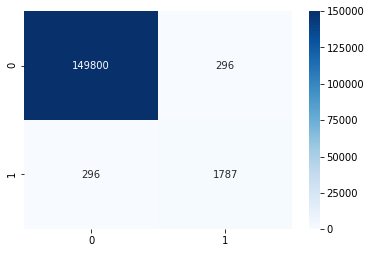

In [110]:
scorer(y_test,y_pred1)